In [1]:
# notebooks/01_data_exploration.ipynb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

pd.set_option('display.max_columns', 120)
sns.set_style('whitegrid')

DATA_PATH = "../data/listings.csv"   # adjust if needed

# If file is large, try reading a sample first
try:
    df = pd.read_csv(DATA_PATH, low_memory=False)
except UnicodeDecodeError:
    df = pd.read_csv(DATA_PATH, encoding='latin-1', low_memory=False)

print("Loaded:", DATA_PATH)
print("Shape:", df.shape)
display(df.head())


Loaded: ../data/listings.csv
Shape: (25801, 18)


,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,number_of_reviews_ltm,license
0,10803,"Room in Deco Apartment, Brunswick East",38901,Lindsay,NaN,Moreland,-37.76606,144.97951,Private room,54.0,5,204,2025-04-23,1.35,1,148,14,NaN
1,12936,St Kilda 1BR+BEACHSIDE+BALCONY+WIFI+AC,50121,The A2C Team,NaN,Port Phillip,-37.85999,144.97662,Entire home/apt,NaN,3,42,2020-03-15,0.23,10,0,0,NaN
2,41836,CLOSE TO CITY & MELBOURNE AIRPORT,182833,Diana,NaN,Darebin,-37.69761,145.00066,Private room,NaN,7,157,2018-08-22,0.89,2,0,0,NaN
3,43429,Tranquil Javanese Studio and Pond!,189684,Allan,NaN,Monash,-37.89983,145.11579,Entire home/apt,128.0,2,269,2025-06-04,1.52,3,165,10,NaN
4,44082,Queen Room in Beautiful House,193031,Vicki,NaN,Frankston,-38.14768,145.14364,Private room,79.0,5,65,2025-04-06,0.37,8,127,6,NaN


In [4]:
# quick info
df.info(show_counts=True)
print("\nTop missing columns:")
display(df.isnull().sum().sort_values(ascending=False).head(20))

print("\nMemory usage (MB):", df.memory_usage(deep=True).sum()/1024**2)
print("\nNumber of unique values (top columns):")
display(df.nunique().sort_values(ascending=False).head(30))


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25801 entries, 0 to 25800
Data columns (total 18 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              25801 non-null  int64  
 1   name                            25801 non-null  object 
 2   host_id                         25801 non-null  int64  
 3   host_name                       25796 non-null  object 
 4   neighbourhood_group             0 non-null      float64
 5   neighbourhood                   25801 non-null  object 
 6   latitude                        25801 non-null  float64
 7   longitude                       25801 non-null  float64
 8   room_type                       25801 non-null  object 
 9   price                           18539 non-null  float64
 10  minimum_nights                  25801 non-null  int64  
 11  number_of_reviews               25801 non-null  int64  
 12  last_review                     

license                           25801
neighbourhood_group               25801
price                              7262
last_review                        4794
reviews_per_month                  4794
host_name                             5
host_id                               0
neighbourhood                         0
latitude                              0
longitude                             0
room_type                             0
name                                  0
minimum_nights                        0
number_of_reviews                     0
calculated_host_listings_count        0
availability_365                      0
number_of_reviews_ltm                 0
id                                    0
dtype: int64


Memory usage (MB): 10.399068832397461

Number of unique values (top columns):


id                                25801
name                              25166
longitude                         19456
latitude                          18957
host_id                           14495
host_name                          6113
last_review                        2390
price                               954
reviews_per_month                   831
number_of_reviews                   503
availability_365                    366
number_of_reviews_ltm               138
minimum_nights                       90
calculated_host_listings_count       66
neighbourhood                        30
room_type                             4
neighbourhood_group                   0
license                               0
dtype: int64

In [6]:
# handle common price columns
price_cols = [c for c in df.columns if 'price' in c.lower()]
print("Price-like columns:", price_cols)

def clean_price(col):
    return (df[col]
            .astype(str)
            .str.replace(r'[\$,£€]', '', regex=True)  # remove common currency symbols
            .str.replace(',', '')                      # remove thousands separators
            .str.extract(r'([0-9]+\.?[0-9]*)')[0]     # extract numeric part
            .astype(float))

if 'price' in df.columns:
    df['price'] = clean_price('price')
else:
    # if there's a different price column, pick first price-like
    if price_cols:
        df['price'] = clean_price(price_cols[0])
    else:
        raise KeyError("No price column found. Check df.columns")


Price-like columns: ['price']


In [8]:
df['price'].describe()


count     18539.000000
mean        241.812611
std        1365.709149
min          17.000000
25%         106.000000
50%         153.000000
75%         229.500000
max      118611.000000
Name: price, dtype: float64

In [12]:
# Remove zero or negative prices (unless legit)
df = df[df['price'] > 0].copy()


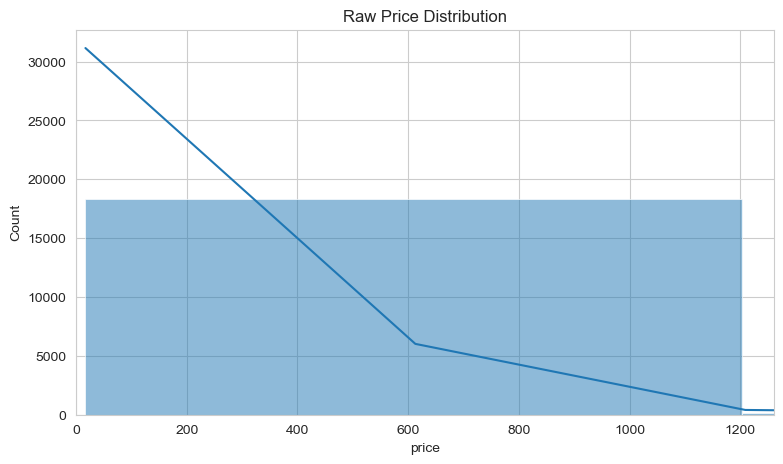

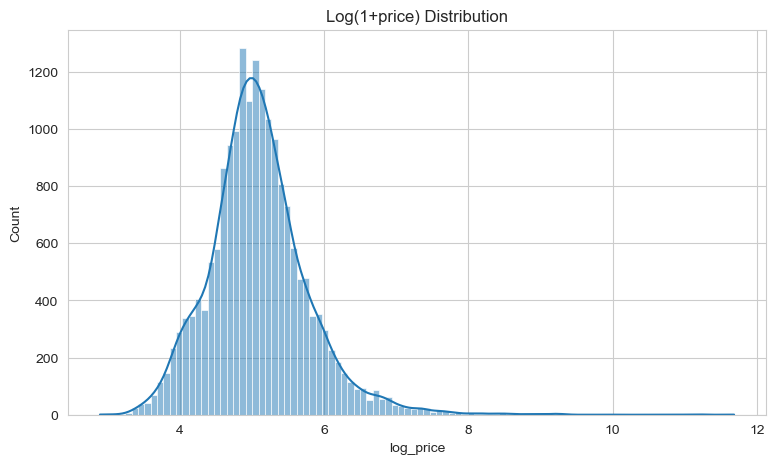

In [14]:
plt.figure(figsize=(9,5))
sns.histplot(df['price'], bins=100, kde=True)
plt.title("Raw Price Distribution")
plt.xlim(0, df['price'].quantile(0.99))  # zooming to 99th percentile
plt.show()

# Log-transformed
df['log_price'] = np.log1p(df['price'])
plt.figure(figsize=(9,5))
sns.histplot(df['log_price'], bins=100, kde=True)
plt.title("Log(1+price) Distribution")
plt.show()


In [16]:
# visualize missingness for top columns
miss = df.isnull().sum().sort_values(ascending=False)
display(miss[miss>0].head(30))

# For numerical columns: you can impute with median
num_cols = df.select_dtypes(include=['number']).columns.tolist()
cat_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()

# Example: impute numeric missing with median (but record it)
for col in ['bathrooms', 'bedrooms', 'beds']:
    if col in df.columns:
        df[col] = df[col].fillna(df[col].median())


license                18539
neighbourhood_group    18539
reviews_per_month       2733
last_review             2733
host_name                  3
dtype: int64

In [22]:
import ast

def parse_amenities(s):
    if pd.isna(s): 
        return []
    try:
        # try literal_eval if it's JSON-like
        val = ast.literal_eval(s)
        if isinstance(val, (list, tuple, set)):
            return [a.strip().lower().strip('"').strip("'") for a in val]
    except Exception:
        # fallback: strip braces and split on comma
        s2 = s.strip('{}[]"')
        return [a.strip().lower().strip('"').strip("'") for a in s2.split(',') if a.strip()]

# create amenities count
if 'amenities' in df.columns:
    df['amenities_list'] = df['amenities'].apply(parse_amenities)
    df['num_amenities'] = df['amenities_list'].apply(len)

    # top 30 most common amenities
    from collections import Counter
    amen_counter = Counter([amen for lst in df['amenities_list'] for amen in lst])
    print("Top amenities:", amen_counter.most_common(20))


In [24]:
# parse last_review if present
if 'last_review' in df.columns:
    df['last_review'] = pd.to_datetime(df['last_review'], errors='coerce')
    df['last_review_year'] = df['last_review'].dt.year
    df['last_review_month'] = df['last_review'].dt.month

# latitude/longitude: check coverage
if {'latitude','longitude'}.issubset(df.columns):
    display(df[['latitude','longitude']].describe())


,latitude,longitude
count,18539.000000,18539.000000
mean,-37.827322,145.013779
std,0.081456,0.168351
min,-38.281502,144.476170
25%,-37.852219,144.953658
50%,-37.817520,144.970400
75%,-37.801406,145.030740
max,-37.440386,145.853180


In [26]:
def remove_outliers_iqr(series, k=1.5):
    q1 = series.quantile(0.25)
    q3 = series.quantile(0.75)
    iqr = q3 - q1
    lower, upper = q1 - k*iqr, q3 + k*iqr
    return series[(series >= lower) & (series <= upper)]

# Example: mark price outliers
lower = df['price'].quantile(0.01)
upper = df['price'].quantile(0.99)
df_trim = df[(df['price']>=lower) & (df['price']<=upper)].copy()
print("Trimmed shape:", df_trim.shape)


Trimmed shape: (18170, 21)


In [28]:
# duplicates
dup_count = df.duplicated(subset=['id']).sum() if 'id' in df.columns else df.duplicated().sum()
print("Duplicate rows:", dup_count)

# drop duplicates if necessary
if 'id' in df.columns:
    df = df.drop_duplicates(subset=['id']).copy()
else:
    df = df.drop_duplicates().copy()


Duplicate rows: 0


In [30]:
CLEAN_PATH = "../data/listings_clean_v1.csv"
df.to_csv(CLEAN_PATH, index=False)
print("Saved cleaned CSV:", CLEAN_PATH)


Saved cleaned CSV: ../data/listings_clean_v1.csv


In [32]:
df_clean = pd.read_csv("../data/listings_clean_v1.csv")
print(df_clean.shape)
df_clean.head()


(18539, 21)


,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,number_of_reviews_ltm,license,log_price,last_review_year,last_review_month
0,10803,"Room in Deco Apartment, Brunswick East",38901,Lindsay,NaN,Moreland,-37.766060,144.979510,Private room,54.0,5,204,2025-04-23,1.35,1,148,14,NaN,4.007333,2025.0,4.0
1,43429,Tranquil Javanese Studio and Pond!,189684,Allan,NaN,Monash,-37.899830,145.115790,Entire home/apt,128.0,2,269,2025-06-04,1.52,3,165,10,NaN,4.859812,2025.0,6.0
2,44082,Queen Room in Beautiful House,193031,Vicki,NaN,Frankston,-38.147680,145.143640,Private room,79.0,5,65,2025-04-06,0.37,8,127,6,NaN,4.382027,2025.0,4.0
3,47100,"Cosy, cute comfortable little home in top loca...",212071,Loren,NaN,Yarra,-37.818371,145.005005,Entire home/apt,116.0,4,180,2025-01-08,1.00,1,16,1,NaN,4.762174,2025.0,1.0
4,51592,Central City Warehouse Apartment,190879,Michelle,NaN,Melbourne,-37.812660,144.963130,Entire home/apt,257.0,2,497,2025-05-24,2.85,1,193,52,NaN,5.552960,2025.0,5.0
